In [1]:
from mnist1d.data import make_dataset, ObjectView
from torch import nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

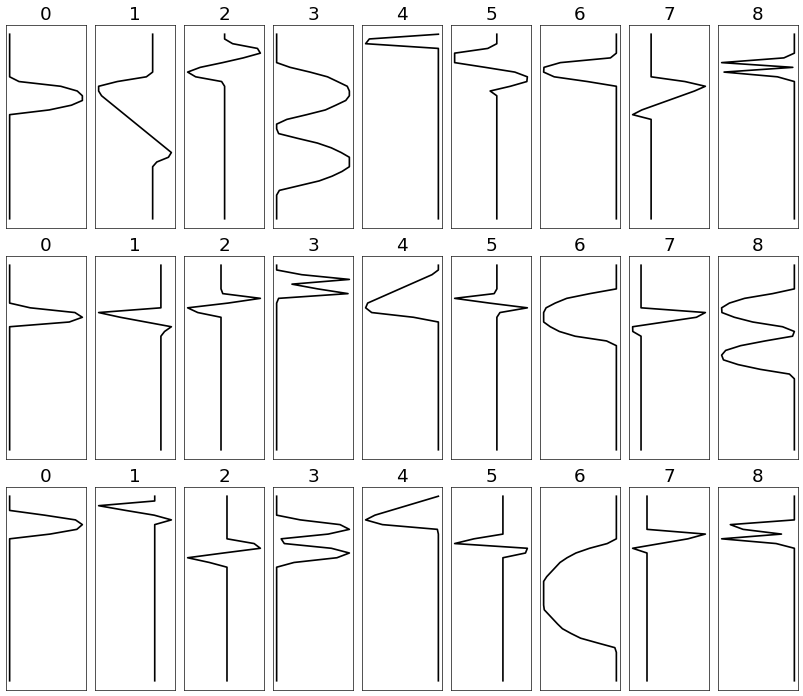

In [2]:
def select_samples(xs, ys, num):
    buckets = {i: [] for i in range(10)}
    class_counts = {i: 0 for i in range(10)}

    for x, y in zip(xs, ys):
        if class_counts[y] < num:
            buckets[y].append(x)
            class_counts[y] += 1

            if all(count == num for count in class_counts.values()):
                break

    selected_xs = [x for digit in range(10) for x in buckets[digit]]
    selected_ys = [digit for digit in range(10) for _ in buckets[digit]]

    return selected_xs, selected_ys


def visualize_mnist_1d(xs, ys, t, num=3):
    xs, ys = select_samples(xs, ys, num=num)

    rows, cols = 3, 9
    ratio = 2.6
    fig = plt.figure(figsize=[cols * 1.5, rows * 1.5 * ratio], dpi=60)

    for r in range(rows):
        for c in range(cols):
            ix = c * rows + r
            x = xs[ix]
            ax = fig.add_subplot(rows, cols, r * cols + c + 1)

            ax.plot(x, t, 'k-', linewidth=2)
            ax.set_title(str(ys[ix]), fontsize=22)

            ax.invert_yaxis()
            ax.set_xticks([]), ax.set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()
    plt.show()


dataset_args = ObjectView({
    'num_samples': 5000,
    'train_split': 0.8,
    'template_len': 12,
    'padding': [0, 100],
    'scale_coeff': 0,
    'max_translation': 30,
    'corr_noise_scale': 0,
    'iid_noise_scale': 0,
    'shear_scale': 0,
    'shuffle_seq': False,
    'final_seq_length': 40,
    'seed': 42,
})

data = make_dataset(dataset_args)

visualize_mnist_1d(data['x'], data['y'], data['t'])

In [3]:
x_train, y_train = data['x'], data['y']
x_test, y_test = data['x_test'], data['y_test']

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (4000, 40), y_train: (4000,)
x_test: (1000, 40), y_test: (1000,)


In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        channels = 25
        self.conv1 = nn.Conv1d(1, channels, 5, stride=2, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.linear = nn.Linear(125, 10)
        # flattened channels -> 10 (assumes input has dim 50)

    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])

    def forward(self, x):
        x = x.view(-1, 1, x.shape[-1])
        h1 = self.conv1(x).relu()
        h2 = self.conv2(h1).relu()
        h3 = self.conv3(h2).relu()
        h3 = h3.view(h3.shape[0], -1)
        return self.linear(h3)


model = CNNModel()
print(f'parameters: {model.count_params()}')
print(model)

parameters: 5210
CNNModel(
  (conv1): Conv1d(1, 25, kernel_size=(5,), stride=(2,), padding=(1,))
  (conv2): Conv1d(25, 25, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(25, 25, kernel_size=(3,), stride=(2,), padding=(1,))
  (linear): Linear(in_features=125, out_features=10, bias=True)
)


In [5]:
x_train_t = torch.tensor(x_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
x_test_t = torch.tensor(x_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

batch_size = 64
num_epochs = 20
train_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size=batch_size, shuffle=True)

model = CNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_accuracies = []

epoch_bar = tqdm(range(num_epochs))
for epoch in epoch_bar:
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    model.eval()
    with torch.no_grad():
        x_val, y_val = x_test_t.to(device), y_test_t.to(device)
        preds = model(x_val).argmax(dim=1)
        val_acc = (preds == y_val).float().mean().item()
        val_accuracies.append(val_acc)

    # Update the single tqdm bar
    epoch_bar.set_postfix({"train_loss": f"{avg_loss:.4f}", "val_acc": f"{val_acc:.4f}"})

100%|██████████| 20/20 [00:06<00:00,  3.20it/s, train_loss=0.1237, val_acc=0.9560]


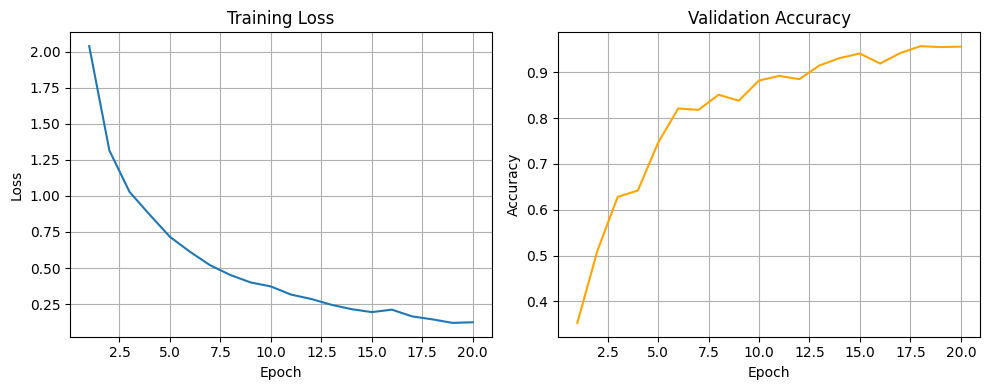

In [6]:
def plot_training_stats(train_losses, val_accuracies, figsize=(10,4)):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=figsize)

    # Training loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    # Validation accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, color='orange')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_stats(train_losses, val_accuracies)